# MCC Feature Extraction
This notebook demonstrates how to analyze speech and re-synthesis speech waveform from speech parameters using [pysptk](https://github.com/r9y9/pysptk) (and other useful speech/audio/music analysis packages). Synthesized audio examples are provided so that you are able to compare synthesis filters on your browser.

## Requirements

- pysptk: https://github.com/r9y9/pysptk
- scipy
- librosa: https://github.com/bmcfee/librosa
- seaborn: https://github.com/mwaskom/seaborn

In [360]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [361]:
import matplotlib
import seaborn
seaborn.set(style="dark")
rcParams['figure.figsize'] = (16, 5)

In [362]:
from IPython.display import Audio
import IPython.display

In [363]:
import numpy as np
import sys
import librosa
import librosa.display
import pysptk
from scipy.io import wavfile
import matplotlib.pyplot as plt 
import python_speech_features as psf

## Data Load

In [364]:
import copy
import fnmatch
import os
import random
import re

import pandas as pd
import json

def find_files(directory, pattern='*.wav'):
    '''Recursively finds all files matching the pattern.'''
    files = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(os.path.join(root, filename))
    return files

## Source parameter extraction

### Framing and windowing

In [365]:
# frame size ideally 20~40ms
frame_length = 512
hop_length = 128

def windowing(x):
    # Note that almost all of pysptk functions assume input array is C-contiguous and np.float4 element type
    # frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    
    x = np.pad(x, [frame_length/2, frame_length/2], 'constant')
    
    frames = []
    while len(x)>=frame_length:
        piece = x[:frame_length]
        x = x[hop_length:]
        # Windowing
        piece *= pysptk.hamming(frame_length)
        frames.append(piece)

    frames = np.array(frames)
    assert frames.shape[1] == frame_length 
    return frames

In [366]:
def upsample(x, target_len):
    upsampled_x = np.repeat(x, hop_length, axis=0)
    upsampled_x = upsampled_x[frame_length/2:target_len]
    diff = target_len - upsampled_x.shape[0]
    print(diff)
    if diff > 0:
        upsampled_x = np.pad(upsampled_x, [[0, diff], [0, 0]], 'constant')
    return upsampled_x 

### F0 estimation

In [367]:
# F0 estimation
def f0_estimation(x):
    f0 = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="f0")
    plot(f0, linewidth=3, label="F0 trajectory estimated by SWIPE'")
    xlim(0, len(f0))
    legend(prop={'size': 16})
    return f0

## Mel-generalized cepstrum extraction

In [368]:
# Order of mel-cepstrum
order = 25
alpha = 0.41
stage = 5
gamma = -1.0 / stage

def mgcep(frames, sr, order=order):
    mgc = pysptk.mgcep(frames, order, min_det=0)
    return mgc

def mcep(frames, sr, order=order):
    mcc = pysptk.mcep(frames, order, alpha, gamma)
    # logH = pysptk.mgc2sp(mgc, alpha, gamma, frame_length).real
    # librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
    # colorbar()
    # title("Spectral envelope estimate from mel-generalized cepstrm")
    # sys.stdout.flush()
    return mcc

def mfcc(frames, sr, order=order):
    mfccs = pysptk.sptk.mfcc(frames, order=order, 
                            fs=sr, alpha=alpha, eps=1.0, 
                            window_len=None, 
                            frame_len=None, 
                            num_filterbanks=35, 
                            cepslift=22, 
                            use_dft=False, 
                            use_hamming=True,
                            czero=False, 
                            power=True)
    return mfccs

def mel_spectrogram(y, sr):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr,
                                              n_fft=frame_length, hop_length=hop_length, 
                                              power=2.0)
    return mel_spec.T

In [369]:
def normalize(M, bounded):
    mean = np.mean(M, axis=0, keepdims=True)
    std = np.std(M, axis=0, keepdims=True)
    normalized_M =(M - mean)/(4*std)
    
    if bounded:
        normalized_M = np.clip(normalized_M, -1, 1)
    
    return normalized_M

In [370]:
def generate_mcc(directory, sample_rate, lc_dir_name, n_mfcc, lc_ext_name=".csv", 
                 overwrite=False, normalized=True, bounded=False):
    files = find_files(directory,  pattern="*.wav")
    for index, filename in enumerate(files):
        try:
            lc_filename = copy.deepcopy(filename)
            if lc_filename.endswith('.wav'):
                lc_filename = lc_filename[:-4] + lc_ext_name
            lc_filename = lc_filename.replace("wav", lc_dir_name)
            if os.path.isfile(lc_filename) and overwrite==False:
                IPython.display.clear_output(wait=True)
                continue
            audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
            frames = windowing(audio)
            # mcc = mcep(frames, sample_rate)
            mcc = mgcep(frames, sample_rate, n_mfcc)
            if normalized:
                mcc = normalize(mcc, bounded)
            alt_mcc = librosa.feature.mfcc(audio, sr=sample_rate, n_mfcc=n_mfcc, 
                                           hop_length=hop_length, n_fft=frame_length).T
            alt_mcc = normalize(alt_mcc, bounded)
            # alt_mcc = mel_spectrogram(audio, sample_rate)
            df = pd.DataFrame(mcc)
            if not os.path.exists(os.path.dirname(lc_filename)):
                try:
                    os.makedirs(os.path.dirname(lc_filename))
                except OSError as exc: # Guard against race condition
                    if exc.errno != errno.EEXIST:
                        raise
            df.to_csv(lc_filename, sep=',', header=None, index=None) 
        except Exception:
            print("Error occurs in "+filename)
        if index % 100 == 0:
            IPython.display.clear_output(wait=True)
            print(str(index)+"/"+str(len(files)))
            print(filename)
            print(mcc.shape)
            print(alt_mcc.shape)
            print(audio.shape)
            begin = 0
            end = 6000
            plt.figure(figsize=(16, 12))
            plt.subplot(311)
            upsampled_mcc = upsample(mcc, len(audio))
            plt.imshow(np.array(upsampled_mcc[begin:end, :].T), aspect="auto", origin="lower")
            plt.colorbar()
            
            plt.subplot(312)
            upsampled_alt_mcc = upsample(alt_mcc, len(audio))
            plt.imshow(np.array(upsampled_alt_mcc[begin:end, :].T), aspect="auto", origin="lower")
            plt.colorbar()
            
            plt.subplot(313)
            plt.xlim((begin, end))
            plt.plot(np.arange(begin, end), audio[begin:end])
            plt.colorbar()
            
            plt.show()
            print(str(mcc.shape))
            print(lc_filename)

In [371]:
def generate_lc_map(directory, old_name, new_name, json_name, config={}):
    files = find_files(directory, pattern="*.wav")
    print("files length: {}".format(len(files)))
    lookup = {}
    for filename in files:
        p_filename = filename.split(directory)[-1]
        p_lc_filename = p_filename.replace(old_name, new_name).replace(".wav", ".csv")
        #p_lc_filename = "../../mfcc40/p225/"+p_filename.replace(".wav", ".csv")
        lookup[p_filename] = p_lc_filename
    lookup["config"] = config
    with open(directory+"/"+json_name, "w") as output:
        print("Export to "+directory+"/"+json_name)
        json.dump(lookup, output)
    print(lookup)

1100/1132
../../cmu_us_slt_arctic/wav/arctic_a0374.wav
(336, 26)
(336, 25)
(42961,)
256
256


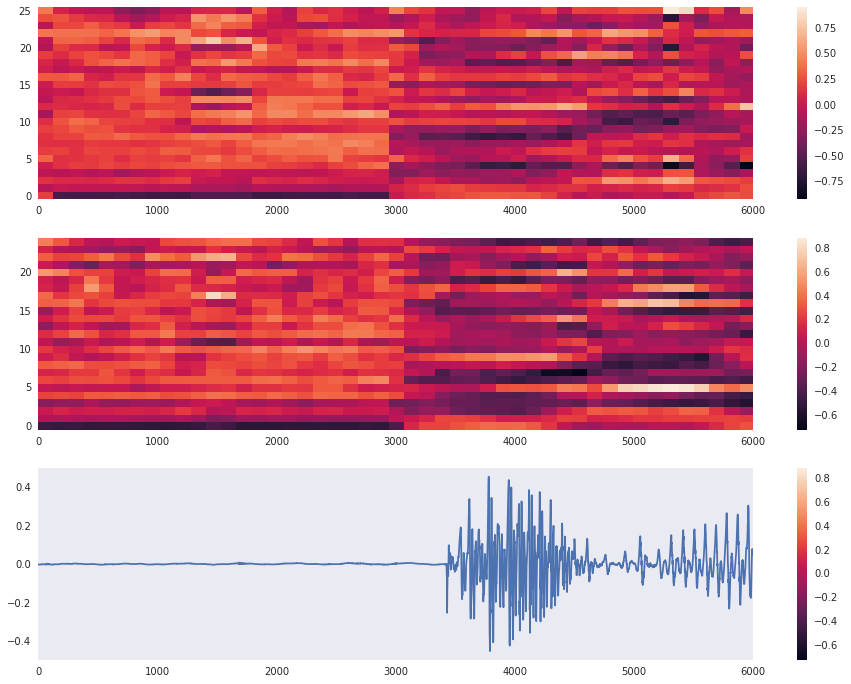

(336, 26)
../../cmu_us_slt_arctic/mgc_26_bounded/arctic_a0374.csv


In [373]:
generate_mcc("../../cmu_us_slt_arctic", 16000, "mgc_26_bounded", 25, lc_ext_name=".csv", overwrite=True, 
             normalized=True, bounded=True)

In [359]:
config = {"frame_length": frame_length, 
          "hop_length": hop_length, 
          "sample_rate": 16000, 
          "num_coeff": 26, 
          "normalized": True, 
          "bounded": True}
generate_lc_map("../../cmu_us_slt_arctic",  "/wav/", "mgc_26/", "mgc_26.json", config)

files length: 1132
Export to ../../cmu_us_slt_arctic/mgc_26.json
{'/wav/arctic_a0340.wav': 'mgc_26/arctic_a0340.csv', '/wav/arctic_b0166.wav': 'mgc_26/arctic_b0166.csv', '/wav/arctic_b0300.wav': 'mgc_26/arctic_b0300.csv', '/wav/arctic_b0463.wav': 'mgc_26/arctic_b0463.csv', '/wav/arctic_a0004.wav': 'mgc_26/arctic_a0004.csv', '/wav/arctic_b0491.wav': 'mgc_26/arctic_b0491.csv', '/wav/arctic_a0475.wav': 'mgc_26/arctic_a0475.csv', '/wav/arctic_b0350.wav': 'mgc_26/arctic_b0350.csv', '/wav/arctic_b0504.wav': 'mgc_26/arctic_b0504.csv', '/wav/arctic_b0241.wav': 'mgc_26/arctic_b0241.csv', '/wav/arctic_b0209.wav': 'mgc_26/arctic_b0209.csv', '/wav/arctic_b0204.wav': 'mgc_26/arctic_b0204.csv', '/wav/arctic_a0057.wav': 'mgc_26/arctic_a0057.csv', '/wav/arctic_a0425.wav': 'mgc_26/arctic_a0425.csv', '/wav/arctic_b0104.wav': 'mgc_26/arctic_b0104.csv', '/wav/arctic_a0109.wav': 'mgc_26/arctic_a0109.csv', '/wav/arctic_b0092.wav': 'mgc_26/arctic_b0092.csv', '/wav/arctic_a0512.wav': 'mgc_26/arctic_a0512.csv'